# MNIST Classifier Tutorial

[Youtube video](https://www.youtube.com/playlist?list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz)

In [5]:
#imports
import torch
import torch.nn as nn  # all the neural network modules
import torch.optim as optim
import torch.nn.functional as F  # relu, tanh, etc
from torch.utils.data import DataLoader  # easier dataset management, helps create mini-btaches to train on
import torchvision.datasets as datasets  # has a lot of nice datasets to use. eg MNIST dataset 
import torchvision.transforms as transforms  # transformations we can perform on our dataset

In [6]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Forward vs backward:

Forward goes something like: Input Layer -> Hidden Layer 1 -> Hidden Layer 2 -> Output Layer

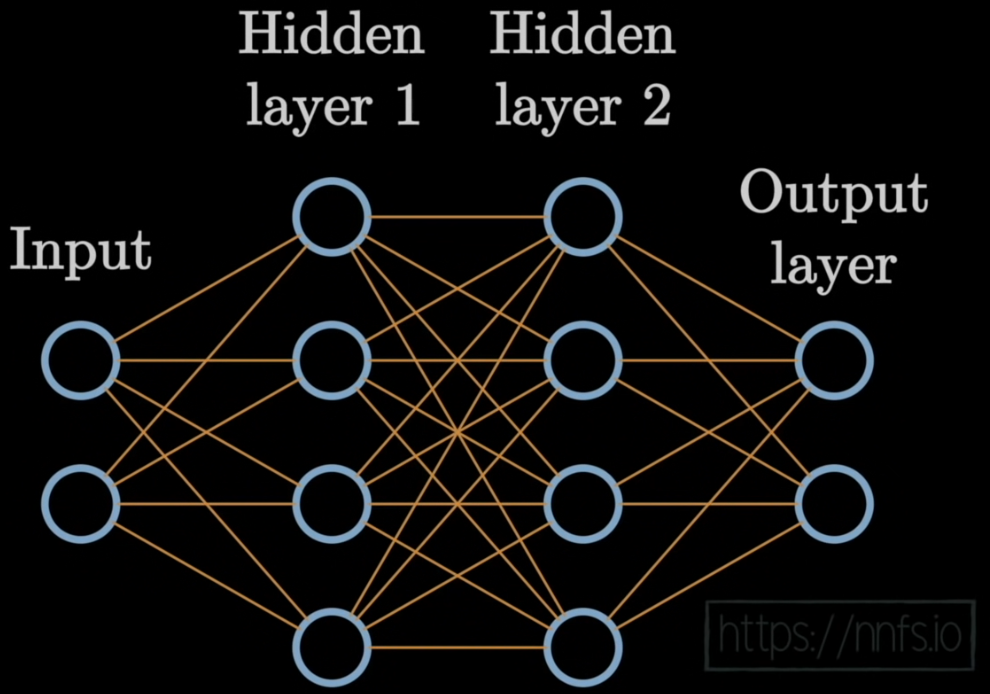

Backward compares the predicted result to actual, then "backward", adjusting the weights such that the

In [7]:
# create fully connected network
class NN(nn.Module):
    def __init__(self, input_size, num_classes):  # MNIST has 28x28=784 images
        super(NN, self).__init__()

        # now create a small neural network of two layers
        self.fc1 = nn.Linear(input_size, 50)  # note this is one of those "hidden layer nodes"
        self.fc2 = nn.Linear(50, num_classes)  # note this is one of those "hidden layer nodes"
    
    # now we define the forward
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# now check that it reutns the correct size data
#model = NN(784, 10)
#x = torch.randn(64, 784)  # 64 = num examples to run (mini-btach size)
#print(model(x).shape) # should return 64x10

In [8]:
# hyperparameters
input_size = 784
num_classes = 10  # guessing this is the number of possible outcomes
learning_rate = 0.001
batch_size = 64
num_epochs = 1  # how many times the network has seen all the images in the dataset

# set the mnist data directory
mnist_data= 'mnist_classifier'

# load data from the MNIST dataset
train_dataset = datasets.MNIST(root=mnist_data, train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # shuffle makes sure we dont have identical images in batches in every epoch

test_dataset = datasets.MNIST(root=mnist_data, train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True) # shuffle makes sure we dont have identical images in batches in every epoch

# initialize the network
model = NN(input_size=input_size, num_classes=num_classes).to(device=device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()  # also seems to be called the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train network
for epoch in range(num_epochs):
    # now loop through eahc batch we have in our training set
    for batch_idx, (data, targets) in enumerate(train_loader):
        # send the data to the gpu
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # torch.Size([64, 1, 28, 28])  = num images, num channels (1=grey), height, width
        # print(data.shape)

        # we need to convert the 28x28 image to a single vector of 784
        data = data.reshape(data.shape[0], -1)

        # perform the forward part of the NN
        scores = model(data)
        loss = criterion(scores, targets)  # compare solution to targets (the correct labels)

        # backward part of the NN
        optimizer.zero_grad()  # set all the gradients to zero for each batch, so it doesnt store the back prop calcs from previous forweard props
        loss.backward()

        # gradeint decent or adam step
        optimizer.step()  # here we update the weights dependeing  on the gradients


# now we check the accuracy on training & test to see how good our model is
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on training data')
    else:
        print('Checking accuracy on test data')


    num_correct = 0
    num_samples = 0
    model.eval()  # set the model to evaluate mode

    with torch.no_grad():  # when we check the accuracy, we do not need to compute the gradients - unneeded computation
        for x,y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            x = x.reshape(x.shape[0], -1)

            scores = model(x) # shape is 64x10 : 64 images x 10 classes
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)  #eg 64
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Checking accuracy on training data
Got 55990 / 60000 with accuracy 93.32
Checking accuracy on test data
Got 9337 / 10000 with accuracy 93.37
